<a href="https://colab.research.google.com/github/fatimaaaaaaa/The-Islamic-Elephant-In-The-Room/blob/main/Thesis_code_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### imports

In [ ]:
import lxml
import re
import os
import pandas as pd
import polars as pl
from tqdm import tqdm
import json
import numpy as np
import spacy
import os.path
from os import path

In [ ]:
def get_base_url(year):
  base_url = f'/content/drive/MyDrive/Thesis/Data/{year}'
  return base_url

### Mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Read/save data

In [ ]:
def read_data(year, n): # Reading the cleaned, separated data files
  df = pl.read_csv(f'/content/drive/MyDrive/Thesis/Data/{year}/{year}-{n}.csv', truncate_ragged_lines=True)
  return df

In [ ]:
# Save file
def save_to_csv(df, filename,polars):
  if(polars):
    df.write_csv(f'{filename}.csv')
  else:
    df.to_csv(f'{filename}.csv', encoding='utf-8-sig')

In [ ]:
# read data
# base_url = get_base_url(2019)

## Data handling

### Downloading data

In [ ]:
# Download and unzip data
# !wget https://www.nb.no/sbfil/tekst/nak_2019.tar
# !tar -xvf nak_2019.tar

# step into unzipped folder
# %cd 2019
 # unzip files
# !for f in *-2019-nob.tar.gz; do tar -xvf "$f"; done

# # Delete all except unzipped data
# !for f in *.tar.gz; do rm "$f"; done

# # Traverse out of folder again
# %cd ..

In [ ]:
%pwd

'/content'

### Splitting data into several files

In [ ]:
!pip install datefinder

In [ ]:
from bs4 import BeautifulSoup
import datefinder

newspapers = ['ap','vg','aa','bt','da','db','dn','fv','nl','sa']


def split_into_smaller_files(year): # n indicates how many files to read
  texts = []
  news_sites = []
  dates= []
  file_counter = 0 # keeps track of number of files saved
  counter = 1


  for newspaper in newspapers:
    print('newspaper:', newspaper)
    path = f'{year}/{newspaper}-{year}-nob'
    # traverse through the folder
    for paths, dirs, files in os.walk(path):
          for f in tqdm(files, total=len(files)):

              # If counter is 2000, save file to csv and reset arrays
              if ((counter % 2000 == 0) or (counter == (len(files)-1))):
                file_counter += 1
                df = pl.DataFrame({ "newssite": news_sites, "date":dates, "article":texts})
                save_to_csv(df, f"/content/drive/MyDrive/Thesis/Data/{year}/{year}-{file_counter}", True)

                print(f"File {file_counter} saved, total counter: {counter}")
                texts = []
                news_sites = []
                dates= []


              counter += 1
              file_path = f'{path}/{f}'
              # print('\nfile',file_path)
              content = []

              try:
                with open(file_path, "r") as fb:
                  # Read each line in the file, readlines() returns a list of lines
                    content = fb.readlines()

                # Combine the lines in the list into a string
                content = "".join(content)
                article = BeautifulSoup(content, "lxml")

                article_body = ""
                if (article.document):
                      article_texts = article.find_all("div",{"type":"text"})
                      if (article_texts == []): continue
                      else:
                        # All found text html elements into article_body array
                        for text in article_texts:
                          article_body = "".join(text.text)

                        # Add article and newssite to arrays
                        texts.append(article_body)
                        news_sites.append(newspaper)

                        # find date attribute and normalize date pattern
                        restructured_date = ''

                        if article.find('attribute',{'name':'date'}):
                          date_attr = article.find('attribute',{'name':'date'})
                          found_date =  datefinder.find_dates(str(date_attr))
                          for i in found_date:
                            restructured_date = i.strftime('%d.%m.%Y')
                        # add date to array
                        dates.append(restructured_date)

              except Exception as e:
                print('exception!', e, e.args)
                continue


In [ ]:
# split_into_smaller_files(2019)

### Pre-Processing

#### Pre-processing helper methods

In [ ]:
# HELPER METHODS
def get_stopwords():
  stopwords_no =  pl.read_csv('/content/drive/MyDrive/Thesis/Data/stopwords.txt')
  # print(stopwords_no)
  nor_sw = []
  for row in stopwords_no.rows():
    nor_sw.append(row[0])
  return nor_sw


In [ ]:
# remove punctuation, short words and stopwords
def remove_stop_short_words(df, column):
  # print('Removing short and stopwords')
  nor_sw = get_stopwords()
  clean_sents = []

  for sentence in df[column]:
    try:
      if(sentence != None):
        # split sentence
        split_sent = sentence.split()
        # Remove short words and stopwords
        clean_sent = ''
        for word in split_sent:
          if str.lower(word) in nor_sw: # if stopword, skip
            continue
          if len(word) < 3: # if short word, skip
            continue
          clean_sent = clean_sent + ' ' + word # else, add to clean_sent
        if (clean_sent != ''): # if clean_sent is not empty, assign it to sentence
          sentence = clean_sent
        # clean_sents.append(sentence) # add sentence to clean_sents array

    except Exception as e:
      print(f'Couldn not parse {sentence}')
      print(f'Reason: {e.args}')

    clean_sents.append(sentence) # add sentence to clean_sents array

  return clean_sents

In [ ]:
# remove nans
def init_cleaning(df):
  df = df.drop_nulls()

  return df

In [ ]:
# Remove duplicates
def remove_dupl(df,subset):
  df = df.unique(subset=subset)

  return df

In [ ]:
# Remove numbers
def remove_numbers_and_punct(df, column):
  # print('Removing numbers and punctuation')
  regex = r'[\,\:\;\%\(\)\+\"\-]'
  clean_sents = []

  for sentence in df[column]:
    if(sentence != None):
      try:
        text = re.sub(regex,'',str(sentence)) # remove punctuations
        sentence = text
      except Exception as e:
        print(f'Couldn not parse {sentence}. {e.args}')
        continue

      try:
        if (re.search(r'\d', sentence)):
          sentence =  re.sub(r'\d','',str(sentence)) # remove numbers
      except Exception as e:
        print(f'Couldn not parse {sentence}. {e.args}')
        continue

    clean_sents.append(sentence)
  return clean_sents

In [ ]:
def lowercase(df, column):
  lowercase_sents = []

  for sentence in df[column]:
    if(sentence != None):
      try:
        text = str.lower(sentence)
        sentence = text
      except Exception as e:
        print(f'Could not parse {sentence}. {e.args}')

    lowercase_sents.append(sentence)
  return lowercase_sents

In [ ]:
def combine_data_files(year, end):
  base_url = get_base_url(year)

  df = pl.DataFrame()

  for i in np.array(range(1,end)):
    if(i % 20 == 0):
      print(i)
    read_df = pl.read_csv(f'{base_url}/spacy/{year}-{i}-spacy.csv')
    df = pl.concat([df, read_df])

  return df

In [ ]:
def get_lemmas_from_spacy_files(df,column, arr):
  # text should appear as a dict
  dates = []
  newssites = []
  articles = []

  for row in df.rows(named=True):
    syntax = row[column]
    json_obj = json.loads(syntax)
    list_of_sentences = json_obj['article']['sentence']

    if arr:
      article = []
    else:
      article = ''

    for sentence in list_of_sentences:
      metadata = sentence['data']
      token_count = 0

      for token in metadata:
        token_lemma = str.lower(token['lemma'])
        if arr:
          article.append(token_lemma)
        else:
          if token_count > 0:
            article += ', ' + token_lemma
          else:
            article += token_lemma

        token_count += 1

    # if sents != None and len(sents) > 0:
    articles.append(article)
    dates.append(row['date'])
    newssites.append(row['newssite'])


  return pl.DataFrame({"newssite": newssites, "date": dates, "article": articles})
  # return pl.DataFrame({'article':articles})

In [ ]:
# look through lemmas for a regex or stirng match
def match_for_articles(df, terms, arr):
  dates = []
  newssites = []
  articles = []
  rel_terms = []
  i = 0

  print('Total rows to traverse:', len(df))
  for row in df.rows(named=True):
    if(i % 100000 == 0):
      print('Rows traversed:', i)

    if arr:
      article = row['article']
    else:
      try:
        article = row['article'].split()
      except Exception as e:
        # print('Exception!', e)
        continue

    for token in article:
        token = str.lower(token)
        token_in_terms_bool = False
        rel_term = ''

        for term in terms:
          # term_regex = r'\w*(' + term + r')\w*' # Regex
          # if re.match(term_regex, token) == None:
          if(str.lower(term) != token): # String Match
            continue
          else:
            token_in_terms_bool = True
            rel_term = term
            break

        # break out of loop if lemma is in terms
        if(token_in_terms_bool):
          articles.append(row['article'])
          dates.append(row['date'])
          newssites.append(row['newssite'])
          rel_terms.append(term)
          break
    i += 1

  # return pl.DataFrame({'article': articles})
  return pl.DataFrame({"newssite": newssites, "date": dates, "article": articles, "relevant_term": rel_terms})


#### spacy

In [ ]:
!python -m spacy download nb_core_news_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 569.4/569.4 MB 3.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('nb_core_news_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# Structure for saving spacy data in json format

'''
article: {
 sentence: {
  text: "the whole sentence",
  data: {
        text: "the",
        pos: "",
        lemma: "",
      },
      {
        text: "whole",
        pos: "",
        lemma: "",
      },
      {
      text:  "sentence",
        pos: "",
        lemma: "",
      },
  },
  sentence: {
    text: "anotehr sentence",
    data: {
        text: "another",
        pos: "",
        lemma: "",
      },
      {
        text: "sentence",
        pos: "",
        lemma: "",
      },
    }
  }
}
'''

'\narticle: {\n sentence: {\n  text: "the whole sentence",\n  data: {\n        text: "the",\n        pos: "",\n        lemma: "",\n      },\n      {\n        text: "whole",\n        pos: "",\n        lemma: "",\n      },\n      {\n      text:  "sentence",\n        pos: "",\n        lemma: "",\n      },\n  },\n  sentence: {\n    text: "anotehr sentence",\n    data: {\n        text: "another",\n        pos: "",\n        lemma: "",\n      },\n      {\n        text: "sentence",\n        pos: "",\n        lemma: "",\n      },\n    }\n  }\n}\n'

In [ ]:
# Spacy handling
import spacy
import pandas as pd
import re

def get_spacy_data(df, column):
  print('Tokenizing and getting metadata of tokens')

  token_df = pd.DataFrame()
  dates = []
  newssites = []
  articles = []

  nlp = spacy.load("nb_core_news_lg")
  counter = 0

  # for row in tqdm(df.rows(named=True)):
  for row in df.rows(named=True):
      if (counter > 0) and (counter % 1000 == 0):
        print("Processed 1000 rows!")


      dates.append(row['date'])
      newssites.append(row['newssite'])
      article_dict = {}

      sents = re.split(r'[\!\?\.]', row[column])

      sentence_arr = []
      for sent in sents: # for each sentence in the article

        if(len(sent) <= 3):
          continue

        doc = nlp(sent)
        token_arr = []
        try:
          for token in doc:
            if(token == None or token.text == None or len(token.text)<=1): continue
            # create a dictionary
            token_dict = {
              "token": str(token.text),
              "lemma": str(token.lemma_),
              "head": str(token.head),
              "head_lemma": str(token.head.lemma_),
              "pos": str(token.pos_),
              "dep": str(token.dep_),
              "morph": str(token.morph)}

            token_arr.append(token_dict) # save {token dict} to [token array]
          sentence_arr.append({"text":sent,"data":token_arr}) # save {dict with token array} in a [sentence array]

        except Exception as e:
          print(f'Something failed at index {counter}. Reason: {e}. \nMoving on..')
          continue

      article_dict = {"article": {"sentence":sentence_arr}}
      articles.append(json.dumps(article_dict)) # save {dict with sentence array} in an [article array]
      counter += 1
  try:
    token_df['newssite'] = newssites
    token_df['date'] = dates
    token_df['syntax'] = articles
  except Exception as e:
     print(f'Something failed at index {counter}. Reason: {e}. \nMoving on..')
  return token_df

In [ ]:
# df = pl.read_csv('/content/drive/MyDrive/Thesis/Data/Eval_Pipeline_folder/2019/2019-3.csv')
# df.head()

In [ ]:
# token_df = get_spacy_data(df, 'article')

#### Pre-processing method

In [ ]:
# PRE PROCESSING

def pre_processing(df,column, new_column):
  print('Preprocessing..')
  # Remove NaNs
  df = init_cleaning(df)

  # Remove duplicates
  df = remove_dupl(df,column)

  # Copy article text column before cleaning the texts
  df = df.with_columns((
         pl.col(column).alias(new_column)
  ))

  df = df.with_columns([
      pl.Series(values=remove_numbers_and_punct(df,new_column)).alias(new_column)
  ])

  # Remove the punctuation, short words and stopwords
  df = df.with_columns([
      pl.Series(values=remove_stop_short_words(df,new_column)).alias(new_column)
  ])

  # spacy here, using pre-processed data
  token_df = get_spacy_data(df, new_column)

  return df, token_df

#### Pre-processing (TIME TO MAKE THIS A BIG METHOD)

* read data
* pre-process data
* then, save the pre-processed AND the microportraits df? yes

In [ ]:
def process_and_save(years, preprocess, spacy, start, base_url):
  print(f'Save preprocessed data? {preprocess}')
  print(f'Save spacy data? {spacy}\n')

  for year in years:
    file_path = f'{base_url}/{year}'

    # traverse through the folder
    n = len([f for f in os.listdir(file_path) if os.path.isfile(os.path.join(file_path, f))])+1
    print('No. of files to create:',n-1)

    for i in np.array(range(start, n)):
      file_name = f'{year}-{i}.csv'
      print(f'File: {file_name}')

      # Read csv file
      # df = read_data(year, i)
      df = pl.read_csv(f'{file_path}/{file_name}', truncate_ragged_lines=True)

      # Pre-process data and save to dataframes (tokens_df = spacy)
      processed_df, tokens_df = pre_processing(df, "article", "preprocessed_article")

      if (preprocess == True):
        # Make new directory if one does not already exist
        if path.exists(f'{file_path}/pre_processed') == False:
          os.mkdir(f'{file_path}/pre_processed')

        # Save to drive
        try:
          save_to_csv(processed_df, f"{file_path}/pre_processed/{year}-{i}-preprocessed", True)
        except Exception as e:
          print(f"Could not save file {year}-{i}-preprocessed.csv! Reason: {e.args}")

      if (spacy == True):
        # Make new directory if one does not already exist
        if path.exists(f'{file_path}/spacy') == False:
          os.mkdir(f'{file_path}/spacy')
        # save dataframes to drive in csvs
        try:
          save_to_csv(tokens_df,f"{file_path}/spacy/{year}-{i}-spacy",False)
        except Exception as e:
          print(f"Could not save file {year}-{i}-spacy.csv! Reason: {e.args}")

      print("Done!\n")

In [ ]:
# Read data
base_url = '/content/drive/MyDrive/Thesis/Data'
# process_and_save([2019, 2018, 2017], True, True, 1, base_url)
# process_and_save([2017], True, True, 1, base_url)

## Defining query terms

In [ ]:
# Target terms for microportraits

target_terms = ['islam','islamsk','muslimsk','muslim','hijab','koran','moské','moske','nikab','niqab','burka']
target_terms_nationalities = ['pakistaner','pakistansk','somalier','somalisk','marokkansk','marokkaner','iraner','iransk','irakisk','iraker','tyrker','tyrkisk','afghaner','afghansk']
target_terms_norsk = ['norskpakistaner','norskpakistansk','norsksomalier','norsksomalisk','norskmarokkansk','norskmarokkaner','norskiraner','norskiransk','norskirakisk','norskiraker','norsktyrker','norsktyrkisk','norskafghaner','norskafghansk']

In [ ]:
all_target_terms = ['islam','islamsk','muslimsk','muslim','hijab','koran','moské','moske','nikab','niqab','burka', 'pakistaner','pakistansk','somalier','somalisk','marokkansk',
                    'marokkaner','iraner','iransk','irakisk','iraker','tyrker','tyrkisk','afghaner','afghansk', 'norskpakistaner','norskpakistansk','norsksomalier','norsksomalisk',
                    'norskmarokkansk','norskmarokkaner','norskiraner','norskiransk','norskirakisk','norskiraker','norsktyrker','norsktyrkisk','norskafghaner','norskafghansk']

In [ ]:
# Counter terms

counter_terms = ['kristen','liberal','norsk','nordmann', 'ateist','sekulær','kristne','vestlig']

# Extracting Descriptions

### Extracting properties and labels

##### Getting Properties
* if token is has dep: amod (modifiers and attributes.. whats that)
    * Descriptions of what modifiers are in UD is found here: https://universaldependencies.org/docs/u/dep/index.html (01.03.24)
* AND token.head is a query term
* THEN ***token = property*** of the query term
* lemma of token is saved as ***decription*** of the query term

In [ ]:
def get_properties(df, term):
  this_token = []
  this_token_lemma = []
  this_term = []
  this_newspaper = []
  this_date = []
  this_token_pos = []

  dependencies = ['neg','advcl','acl','appos']

  for row in df.rows(named=True):

    syntax = row['syntax']
    json_obj = json.loads(syntax)
    list_of_sentences = json_obj['article']['sentence']

    for sentence in list_of_sentences:
      metadata = sentence['data']
      text = sentence['text']
      sentence_printed = 0

      for token in metadata:
        dep = token['dep']
        head = str.lower(token['head_lemma'])
        token_lemma = str.lower(token['lemma'])
        pos = token['pos']

        pattern = r'[\w]+mod'

        if(re.match(pattern, dep) != None or dep in dependencies):
          if(head == term):
            # if(sentence_printed == 0):
              # print(text)
              # sentence_printed = 1

            # print(f'Term: "{head}" has property "{token_lemma}". Property POS is: {pos}')

            # print('dep', token['dep'])
            # print('head is in target terms AND token is amod')
            this_token.append(token['token'])
            this_token_lemma.append(token_lemma)
            this_term.append(head)
            this_token_pos.append(pos)
            this_newspaper.append(row['newssite'])
            this_date.append(row['date'])

  df = pl.DataFrame({ "property_(token)": this_token, "description": this_token_lemma, "query_term_(head)": this_term, "pos": this_token_pos, "date":this_date, "newspaper":this_newspaper})

  return df


In [ ]:
# for i in np.array(range(1,5)):
#   df = pl.read_csv(f'{base_url}/spacy/2019-{i}-spacy.csv')
#   x = get_properties(df)
#   if(x.is_empty()):
#     continue
#   print(x)

##### Getting Labels
* if query term is modifier or attribute of token
* then extract head of token as ***label*** of term

In [ ]:
def get_labels(df,term):
  this_token = []
  this_token_lemma = []
  this_head = []
  this_head_lemma = []
  this_head_pos = []
  this_newspaper = []
  this_date = []

  dependencies = ['neg','advcl','acl','appos']

  for row in df.rows(named=True):

    syntax = row['syntax']
    json_obj = json.loads(syntax)
    list_of_sentences = json_obj['article']['sentence']

    for sentence in list_of_sentences:
      metadata = sentence['data']
      text = sentence['text']
      sentence_printed = 0

      for token in metadata:
        token_lemma = str.lower(token['lemma'])

        if token_lemma != term:
          continue

        dep = token['dep']
        head = str.lower(token['head'])
        head_lemma = str.lower(token['head_lemma'])
        head_pos = nlp(token['head'])[0].pos_
        pattern = r'[\w]+mod'
        pos = token['pos']

        if(re.match(pattern, dep) != None or dep in dependencies):
            # if(sentence_printed == 0):
              # print(text)
              # sentence_printed = 1

            # print(f'head {head} has relation {dep} to term {token_lemma}. Head has pos: {head_pos}\n')

            this_token.append(token['token'])
            this_token_lemma.append(token_lemma)
            this_head.append(head)
            this_head_pos.append(head_pos)
            this_head_lemma.append(head_lemma)
            this_newspaper.append(row['newssite'])
            this_date.append(row['date'])

  df = pl.DataFrame({ "query_term": this_token, "token_lemma": this_token_lemma, "label_(head)": this_head, "description": this_head_lemma, "pos":this_head_pos, "date":this_date, "newspaper":this_newspaper})

  return df

In [ ]:
# for i in np.array(range(1, 5)):
#   df = pl.read_csv(f'{base_url}/spacy/2019-{i}-spacy.csv')
#   x = get_labels(df)
#   if(x.is_empty()):
#     continue
#   print(x)

##### Getting roles

* three roles: agent, patient and recipient


In [ ]:

def get_roles(df, term):
  this_token = []
  this_token_lemma = []
  this_term = []
  this_newspaper = []
  this_date = []
  this_head_pos = []
  this_role = []

  for row in df.rows(named=True):

    # read from dictionary format to json format
    syntax = row['syntax']
    json_obj = json.loads(syntax)
    list_of_sentences = json_obj['article']['sentence']

    for sentence in list_of_sentences:
      metadata = sentence['data']
      text = sentence['text']
      sentence_printed = 0

      for token in metadata:
        token_lemma = str.lower(token['lemma'])

        # IF REGEX, UNCOMMENT
        # term_regex = r'(' + term + r')\S*'
        # if re.match(term_regex,token_lemma) == None:
        #   continue

        if token_lemma != term:
          continue

        dep = token['dep']
        head = str.lower(token['head_lemma'])
        # token_ = str.lower(token['lemma'])
        pos = token['pos']

        head_nlp = nlp(head)[0]
        head_pos = head_nlp.pos_
        head_tense = head_nlp.morph

        roles_deps  = ['nsubj','obl', 'obj','nsubjpass', 'iobj']
        patients_deps = ['obj','nsubjpass']
        recipients_dep = 'iobj'

        # if(dep in roles_deps and head_pos == "VERB" and token_lemma == term):
        if(dep in roles_deps):
            if(sentence_printed == 0):
              # print(text)
              sentence_printed = 1

            role = "agent"
            if dep in patients_deps:
              role = "patient"
            elif dep == recipients_dep:
              role = "recipient"

            # print(f'Term {token_lemma} has relation "{dep}" to head "{head}". Head POS: {head_pos}')
            # print(f'Term {token_lemma} has role "{role}" in event "{head}", head tense: "{head_tense}". \n')

            this_token.append(token['token'])
            this_token_lemma.append(token_lemma)
            this_term.append(head)
            this_newspaper.append(row['newssite'])
            this_date.append(row['date'])
            this_role.append(role)
            this_head_pos.append(head_pos)

  df = pl.DataFrame({ "role": this_role, "this_token": this_token, "query_term": this_token_lemma, "description": this_term, "pos":this_head_pos ,"date":this_date, "newspaper":this_newspaper})

  return df

#### Get descriptions

In [ ]:
def get_descriptions(term, year, term_list, base_url):
  # base_url = get_base_url(year)

  found_properties = False
  found_labels = False
  found_roles = False

  df_all_props = pl.DataFrame()
  df_all_labels = pl.DataFrame()
  df_all_roles = pl.DataFrame()

  prop_count = 0
  label_count = 0
  role_count = 0

  prop_file_count = 1
  label_file_count = 1
  role_file_count = 1

  file_path = f'{base_url}/spacy'

  n = len([f for f in os.listdir(file_path) if os.path.isfile(os.path.join(file_path, f))])+1

  print(f'Getting descriptions for term "{term}"')
  print(f'files to traverse:', n)

  for i in np.array(range(1,n)):
    file_name = f'{file_path}/{year}-{i}-spacy.csv'
    print('PATH:', file_name)

    if(i % 50 == 0):
      print('Traversed 50 files! At file nr:',i)

    df = pl.read_csv(file_name)

    df_props = get_properties(df,term)
    df_labels = get_labels(df,term)
    df_roles = get_roles(df,term)

    # Properties
    if(not df_props.is_empty() and len(df_props) > 0):
      df_all_props = pl.concat([df_all_props, df_props])
      prop_count += 1

    # Labels
    if(not df_labels.is_empty() and len(df_labels) > 0):
      df_all_labels = pl.concat([df_all_labels, df_labels])
      label_count += 1

    # Roles
    if(not df_roles.is_empty() and len(df_roles) > 0):
      df_all_roles = pl.concat([df_all_roles, df_roles])
      role_count += 1

    if(i == n-1):
      print(f'Saving descriptions for term "{term}"')

      # SAVE PROPERTIES
      # check if paths exist
      path_to_save_file = f'{base_url}/microportraits/{term_list}/properties'

      if path.exists(path_to_save_file) == False:
        os.makedirs(path_to_save_file)

      save_to_csv(df_all_props, f'{path_to_save_file}/{term}_{prop_file_count}', True)

      # SAVE LABELS
      # check if paths exist
      path_to_save_file = f'{base_url}/microportraits/{term_list}/labels'

      if path.exists(path_to_save_file) == False:
        os.makedirs(path_to_save_file)

      save_to_csv(df_all_labels, f'{path_to_save_file}/{term}_{label_file_count}', True)

      # SAVE ROLES
      # check if paths exist
      path_to_save_file = f'{base_url}/microportraits/{term_list}/roles'

      if path.exists(path_to_save_file) == False:
        os.makedirs(path_to_save_file)

      save_to_csv(df_all_roles, f'{path_to_save_file}/{term}_{role_file_count}', True)

  print("\nProperties")
  print(df_all_props)
  print(prop_count)

  print("\nLabels")
  print(df_all_labels)
  print(label_count)

  print("\nRoles")
  print(df_all_roles)
  print(role_count)

  print('\n')

#### Call Get Descriptions

In [ ]:
years = [2019, 2018, 2017]

In [ ]:
for year in years:
  print('Year:', year)
  for term in target_terms:
   get_descriptions(term, year, "target_term")

  base_url = get_base_url(year)
  for term in target_terms_nationalities:
    get_descriptions(term, year, "target_terms_nationalities", base_url)

  for term in target_terms_norsk:
    get_descriptions(term, year, "target_terms_nationalities", base_url)

In [ ]:
for year in years:
  print('Year:', year)
  base_url = get_base_url(year)
  for term in counter_terms:
   get_descriptions(term, year, "counter_terms", base_url)

## Combining CSVs

#### Combining microportraits by year, separating by term

In [ ]:
def combining_microportraits(term_type, term_list):
  years = ['2019','2018','2017']
  desc_types = ['properties','labels','roles']

  print(f'for list {term_type}')

  for desc_type in desc_types:
    print(f'Combining {desc_type}..')

    for term in term_list:
      combined_df = pl.DataFrame()

      for year in years:

        base_url = '/content/drive/MyDrive/Thesis/Data/Over the years/microportraits'
        reading_path = f'{base_url}/{term_type}/{desc_type}/{term}.csv'

        try:
          df = pl.read_csv(reading_path)
        except Exception as e:
          print(f'Exception! for {term} in year {year}', e)
          continue

        df = df.select([pl.col('^*query_term*$'), pl.col('description')])
        value_c = df['description'].value_counts(sort=True)[:n]
        print(value_c)

        combined_df = pl.concat([combined_df, df])

      writing_path = f'{base_url}/{term_type}/{desc_type}'

      if path.exists(writing_path) == False:
          os.makedirs(writing_path)


      # print(combined_df.value_counts())

      # save_to_csv(combined_df,f'{writing_path}/top_10_{desc_type}', True)

In [ ]:
combining_microportraits('counter_terms', counter_terms)
combining_microportraits('target_term', target_terms)
combining_microportraits('target_terms_nationalities', target_terms_nationalities)
combining_microportraits('target_terms_norsk', target_terms_norsk)

## Defining Frequency counts methods

In [ ]:
# Make a mega csv for each term for each description
# Find the top 10 of each description type

def get_top_10_descriptions(description_type, term, term_type, year, n):
  base_url = get_base_url(year)
  file_path = f'{base_url}/microportraits/{term_type}/{description_type}/{term}_1.csv'
  roles = ['agent','patient','recipient']

  df = pl.DataFrame()
  top_10 = pl.DataFrame()

  column = ''
  role = ''

  print(f'Term "{term}"')

  try:
    df = pl.read_csv(file_path)
  except Exception as e:
    print('Exception!', e)
    return

  print(f'Length: {len(df)}')
  path_to_save_file = f'{base_url}/microportraits/top_{n}s/freq_counts/{term_type}/{description_type}'
  if path.exists(path_to_save_file) == False:
        os.makedirs(path_to_save_file)

  # Roles

  column = 'description'

  if(description_type == 'roles'):
    for role in roles:
      df2 = df.filter(pl.col('role') == role)

      top_10 = df2[column].value_counts(sort=True)[:n]
      # top_10 = top_10.rename({'event_(this_token_head)':'event'})

      save_to_csv(top_10, f'{path_to_save_file}/{role}_{term}', True)

  # Properties and labels
  else:
    top_10 = df[column].value_counts(sort=True)[:n]

    save_to_csv(top_10, f'{path_to_save_file}/{term}', True)


In [ ]:
# Get top 10/100 roles for all roles

def get_top_10_for_all_roles(year, term_type, term_list, n):

  base_url = get_base_url(year)
  path = f'{base_url}/microportraits/top_{n}s/freq_counts/{term_type}/roles'
  data = {"description": [], "count": [], "role": []}

  for term in term_list:
    all_roles = []

    # Patient
    try:
      df_p = pl.read_csv(f'{path}/patient_{term}.csv')
      df_p = df_p.with_columns(pl.lit('patient').alias('role'))

      all_events = df_p.get_columns()[0]
      all_count = df_p.get_columns()[1].cast(pl.Int64)
      all_roles = df_p.get_columns()[2]
    except Exception as e:
      print('Exception!', e)
      continue

    # Agents
    try:
      df_a = pl.read_csv(f'{path}/agent_{term}.csv')
      df_a = df_a.with_columns(pl.lit('agent').alias('role'))

      all_events.append(df_a.get_columns()[0])
      all_count.append(df_a.get_columns()[1].cast(pl.Int64))
      all_roles.append(df_a.get_columns()[2])
    except Exception as e:
      print('Exception!', e)
      continue

    # Recipient
    try:
      df_r = pl.read_csv(f'{path}/recipient_{term}.csv')
      df_r = df_r.with_columns(pl.lit('recipient').alias('role'))

      all_events.append(df_r.get_columns()[0])
      all_count.append(df_r.get_columns()[1].cast(pl.Int64))
      all_roles.append(df_r.get_columns()[2])
    except Exception as e:
      print('Exception!', e)
      continue

    df_all_roles = pl.DataFrame({
        "event" : all_events,
        "count":all_count,
        "role":all_roles
    })

    top_10 = df_all_roles.sort(pl.col('count'), descending=True)[:n]
    print(f'Number of microportraits for all roles: {len(df_all_roles)}')

    # print(df_all_roles)
    save_to_csv(top_10, f"{path}/all_roles_{term}", True)

# Get articles to manually extract microportraits

In [ ]:
pl.Config.set_fmt_str_lengths(100)

polars.config.Config

In [ ]:
# Extract 10 articles per term category
# 10 * 5 categories = 50 articles

# Get sample from each term category

def get_articles():
  # Get all pre-processed articles
  articles = []
  dates = []
  newssites = []

  years = [2019,2018,2017]

  for year in years:
    print(year)

    file_path = get_base_url(year)
    n = len([f for f in os.listdir(file_path) if os.path.isfile(os.path.join(file_path, f))])+1

    print('articles to traverse:', n-1)

    for i in range(1,n):
      df = pl.read_csv(file_path + f'/{year}-{i}.csv', truncate_ragged_lines=True)

      for row in df.rows(named=True):
        # print(row['article'])
        articles.append(row['article'])
        newssites.append(row['newssite'])
        dates.append(row['date'])


    print('----')

  articles_df = pl.DataFrame({'article': articles, 'newssite': newssites, 'date': dates})

  print('Collected all articles from all years! Number of articles: ', len(articles_df))
  return articles_df

In [ ]:
df = get_articles() # combined list of articles from all years

2019
articles to traverse: 89
----
2018
articles to traverse: 104
----
2017
articles to traverse: 119
----
Collected all articles from all years! Number of articles:  490012


In [ ]:
base_url = get_base_url('Over the years/Eval_set')

##### Target terms

In [ ]:
target_match_df = match_for_articles(df, target_terms, False)

Total rows to traverse: 490012
Rows traversed: 0
Rows traversed: 100000
Rows traversed: 200000
Rows traversed: 300000
Rows traversed: 400000


In [ ]:
print(target_match_df['relevant_term'].value_counts(sort=True))

shape: (11, 2)
┌───────────────┬───────┐
│ relevant_term ┆ count │
│ ---           ┆ ---   │
│ str           ┆ u32   │
╞═══════════════╪═══════╡
│ islam         ┆ 618   │
│ islamsk       ┆ 504   │
│ muslimsk      ┆ 444   │
│ hijab         ┆ 254   │
│ …             ┆ …     │
│ burka         ┆ 49    │
│ moske         ┆ 38    │
│ niqab         ┆ 16    │
│ koran         ┆ 5     │
└───────────────┴───────┘


In [ ]:
target_sample_df = target_match_df.sample(n=10, shuffle=True)
print(target_sample_df['relevant_term'].head(10))

shape: (10,)
Series: 'relevant_term' [str]
[
	"muslimsk"
	"islam"
	"moské"
	"islamsk"
	"hijab"
	"islam"
	"islam"
	"muslim"
	"muslim"
	"hijab"
]


In [ ]:
# save
save_to_csv(target_sample_df, f'{base_url}/target_term', True)

##### Counter terms

In [ ]:
counter_match_df = match_for_articles(df, counter_terms, False)

Total rows to traverse: 490012
Rows traversed: 0
Rows traversed: 100000
Rows traversed: 200000
Rows traversed: 300000
Rows traversed: 400000


In [ ]:
print(counter_match_df['relevant_term'].value_counts(sort=True))

shape: (8, 2)
┌───────────────┬───────┐
│ relevant_term ┆ count │
│ ---           ┆ ---   │
│ str           ┆ u32   │
╞═══════════════╪═══════╡
│ norsk         ┆ 37423 │
│ nordmann      ┆ 1480  │
│ kristne       ┆ 1121  │
│ vestlig       ┆ 493   │
│ kristen       ┆ 462   │
│ liberal       ┆ 456   │
│ sekulær       ┆ 51    │
│ ateist        ┆ 24    │
└───────────────┴───────┘


In [ ]:
# counter terms
# counter_sample_df = counter_match_df.sample(n=10, shuffle=True)
without_norsk_df = counter_match_df.filter(pl.col('relevant_term') != 'norsk')
without_norsk_df = without_norsk_df.sample(n=10, shuffle=True)
print(without_norsk_df['relevant_term'].head(10))

shape: (10,)
Series: 'relevant_term' [str]
[
	"sekulær"
	"nordmann"
	"kristen"
	"nordmann"
	"vestlig"
	"vestlig"
	"kristen"
	"liberal"
	"kristne"
	"nordmann"
]


In [ ]:
save_to_csv(without_norsk_df, f'{base_url}/counter_terms', True)

##### Target terms nationalities

In [ ]:
nat_match_df = match_for_articles(df, target_terms_nationalities, False)

Total rows to traverse: 490012
Rows traversed: 0
Rows traversed: 100000
Rows traversed: 200000
Rows traversed: 300000
Rows traversed: 400000


In [ ]:
print(nat_match_df['relevant_term'].value_counts(sort=True))

shape: (14, 2)
┌───────────────┬───────┐
│ relevant_term ┆ count │
│ ---           ┆ ---   │
│ str           ┆ u32   │
╞═══════════════╪═══════╡
│ tyrkisk       ┆ 674   │
│ iransk        ┆ 419   │
│ afghansk      ┆ 179   │
│ pakistansk    ┆ 176   │
│ …             ┆ …     │
│ somalier      ┆ 13    │
│ pakistaner    ┆ 9     │
│ iraner        ┆ 9     │
│ marokkaner    ┆ 6     │
└───────────────┴───────┘


In [ ]:
# target terms nationalities
nat_sample_df = nat_match_df.sample(n=10, shuffle=True)
print(nat_sample_df['relevant_term'].head(10))

shape: (10,)
Series: 'relevant_term' [str]
[
	"somalisk"
	"tyrkisk"
	"tyrkisk"
	"irakisk"
	"pakistansk"
	"afghansk"
	"afghansk"
	"pakistansk"
	"pakistaner"
	"iransk"
]


In [ ]:
save_to_csv(nat_sample_df, f'{base_url}/target_terms_nationalities', True)

##### Target terms norsk

In [ ]:
nor_match_df = match_for_articles(df, target_terms_norsk, False)

Total rows to traverse: 490012
Rows traversed: 0
Rows traversed: 100000
Rows traversed: 200000
Rows traversed: 300000
Rows traversed: 400000


In [ ]:
print(nor_match_df['relevant_term'].value_counts(sort=True))

shape: (7, 2)
┌─────────────────┬───────┐
│ relevant_term   ┆ count │
│ ---             ┆ ---   │
│ str             ┆ u32   │
╞═════════════════╪═══════╡
│ norskpakistaner ┆ 23    │
│ norsksomalier   ┆ 9     │
│ norskiraner     ┆ 7     │
│ norsksomalisk   ┆ 6     │
│ norskpakistansk ┆ 6     │
│ norskiraker     ┆ 5     │
│ norskmarokkaner ┆ 2     │
└─────────────────┴───────┘


In [ ]:
# target terms norsk
nor_sample_df = nor_match_df.sample(n=10, shuffle=True)
print(nor_sample_df['relevant_term'].head(10))

shape: (10,)
Series: 'relevant_term' [str]
[
	"norskiraker"
	"norsksomalier"
	"norskiraker"
	"norskiraner"
	"norskpakistaner"
	"norskiraker"
	"norskpakistaner"
	"norsksomalier"
	"norskiraner"
	"norskpakistaner"
]


In [ ]:
save_to_csv(nor_sample_df, f'{base_url}/target_terms_norsk', True)

# Topic Modelling

source: https://towardsdatascience.com/6-tips-to-optimize-an-nlp-topic-model-for-interpretability-20742f3047e2, https://nicharuc.github.io/topic_modeling/

##### code

In [ ]:
topic_terms = target_terms + target_terms_nationalities + target_terms_norsk + counter_terms

In [ ]:
# Do this per year, per term category

toknes_df = pl.DataFrame()

for year in [2019, 2018, 2017]:
  print('Year:', year)

  # base_url = get_base_url(year)
  # file_path = f'{base_url}/spacy'
  file_path = f'/content/drive/MyDrive/Thesis/Data/Eval_Pipeline_folder/{year}/spacy'

  n = len([f for f in os.listdir(file_path) if os.path.isfile(os.path.join(file_path, f))])+1
  # n = 6 # Files_for_manual_inspection
  print('No. of files to traverse:',n-1)

  for i in np.array(range(1,n)):
    if i % 20 == 0:
      print(f'path: {file_path}/{year}-{i}-spacy.csv')

    tokens_list = pl.read_csv(f'{file_path}/{year}-{i}-spacy.csv')
    tokens = only_relevant_articles(tokens_list,"syntax", ( target_terms_norsk ))
    # tokens = prepare_articles_for_lda(tokens2, 'syntax')

    if(len(tokens)) > 0:
      toknes_df = pl.concat([toknes_df, tokens])

  print('\n')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Year: 2019
No. of files to traverse: 5


Year: 2018
No. of files to traverse: 5


Year: 2017
No. of files to traverse: 5




In [ ]:
# print(len(tokens_list))
print(len(toknes_df)) # only relevant articles
# print(toknes_df.head)

18


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


###### /////////////// bigrams start ///////////////

In [ ]:
import nltk

# Example for detecting bigrams
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder =nltk.collocations.BigramCollocationFinder\
.from_documents([comment.split() for comment in toknes_df['article']])

# Filter only those that occur at least 50 times
finder.apply_freq_filter(50)
bigram_scores = finder.score_ngrams(bigram_measures.pmi)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
finder.nbest(bigram_measures.pmi, 50)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[]

In [ ]:
bigram_pmi = pd.DataFrame(bigram_scores)
bigram_pmi.head()
bigram_pmi.columns = ['bigram', 'pmi']
bigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ValueError: Length mismatch: Expected axis has 0 elements, new values have 2 elements

In [ ]:
# print(len(bigram_pmi))
bigram_pmi

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


""


In [ ]:

def bigram_filter(bigram):
    tag = nltk.pos_tag(bigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['NN']:
        return False
    # if bigram[0] in stop_word_list or bigram[1] in stop_word_list:
    #     return False
    if 'n' in bigram or 't' in bigram:
        return False
    if 'PRON' in bigram:
        return False
    return True

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
nltk.download('averaged_perceptron_tagger')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:

filtered_bigram = bigram_pmi[bigram_pmi.apply(lambda bigram:\
                                              bigram_filter(bigram['bigram'])\
                                              and bigram.pmi > 5, axis = 1)][:500]

bigrams = [' '.join(x) for x in filtered_bigram.bigram.values if len(x[0]) > 2 or len(x[1]) > 2]

In [ ]:
# examples of bigrams
print(len(bigrams))
bigrams[:20]

###### /////////////// bigrams slutt ///////////////




###### /////// trigrams start ///////////

In [ ]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
tfinder = nltk.collocations.TrigramCollocationFinder.from_documents([comment.split() for comment in toknes_df['article']])
# Filter only those that occur at least 50 times
tfinder.apply_freq_filter(50)
trigram_scores = tfinder.score_ngrams(trigram_measures.pmi)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
trigram_pmi = pd.DataFrame(trigram_scores)
trigram_pmi.columns = ['trigram', 'pmi']
trigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

In [ ]:
print(len(trigram_pmi))
trigram_pmi.head()

0


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


""


In [ ]:
# Filter for trigrams with only noun-type structures
def trigram_filter(trigram):
    tag = nltk.pos_tag(trigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['JJ','NN']:
        return False
    # if trigram[0] in stop_word_list or trigram[-1] in stop_word_list or trigram[1] in stop_word_list:
    #     return False
    if 'n' in trigram or 't' in trigram:
         return False
    if 'PRON' in trigram:
        return False
    return True

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
filtered_trigram = trigram_pmi[trigram_pmi.apply(lambda trigram: \
                                                 trigram_filter(trigram['trigram'])\
                                                 and trigram.pmi > 5, axis = 1)][:500] # lmao its only 9 trigrams

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
filtered_trigram.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


""


In [ ]:
trigrams = [' '.join(x) for x in filtered_trigram.trigram.values if len(x[0]) > 2 or len(x[1]) > 2 and len(x[2]) > 2]

In [ ]:
# examples of trigrams
print(len(trigrams))
trigrams[:30]

In [ ]:
# Concatenate n-grams

def replace_ngram(x):
    for gram in bigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    for gram in trigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    return x

reviews_w_ngrams = toknes_df.to_pandas()
reviews_w_ngrams = reviews_w_ngrams['article'].map(lambda x: replace_ngram(x))

In [ ]:
# tokenize reviews + remove stop words + remove names + remove words with less than 2 characters
reviews_w_ngrams = reviews_w_ngrams.map(lambda x: [word for word in x.split() if len(word) > 2])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
reviews_w_ngrams.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,newssite,date,article
0,[],[15.07.2019],"[hverken, krekar, tiltalte, norge, gammel, nor..."
1,[],[30.03.2018],"[tiltalte, gammel, norskiraker, bosatt, fredri..."
2,[],[10.12.2018],"[krekar, tiltalte, norge, gammel, norskiraker,..."
3,[],[17.09.2018],"[gammel, norskpakistaner, siktet, drapet]"
4,[],[31.10.2018],"[tyder, etterretningstjenesten, iranske, revol..."


###### /////// trigrams slutt ///////////

###### ////////// nouns only filtering /////////

In [ ]:
# Filter for only nouns

def noun_only(x):
    pos_comment = nltk.pos_tag(x)
    filtered = [word[0] for word in pos_comment if word[1] in ['NN'] or word[1] in ['VB']]
    return filtered

final_reviews = reviews_w_ngrams.head().map(noun_only)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# final_reviews.head()
final_reviews = reviews_w_ngrams
print(len(reviews_w_ngrams))
final_reviews

7


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,newssite,date,article
0,[],[15.07.2019],"[hverken, krekar, tiltalte, norge, gammel, nor..."
1,[],[30.03.2018],"[tiltalte, gammel, norskiraker, bosatt, fredri..."
2,[],[10.12.2018],"[krekar, tiltalte, norge, gammel, norskiraker,..."
3,[],[17.09.2018],"[gammel, norskpakistaner, siktet, drapet]"
4,[],[31.10.2018],"[tyder, etterretningstjenesten, iranske, revol..."
5,[],[02.03.2017],"[«opak», «opac», «maxopak», politiet, norskpak..."
6,[],[13.01.2017],"[kveld, pågrep, politiet, medlemmer, agjengen,..."


In [ ]:
# save final reviews
final_reviews.to_csv('final_reviews.csv', index=False)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


###### ////////// nouns only filtering slutt/////////

###### ////////// LDA  /////////

In [ ]:
import gensim
from gensim import corpora
# Visualizing the results
import pyLDAvis.gensim
import pickle
import pyLDAvis

In [ ]:
def remove_word_from_list(list_to_modify, word_to_remove):
  return [value for value in list_to_modify if value != word_to_remove]

final_reviews = toknes_df['article'].to_list()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
final_reviews = [review.split() if isinstance(review, str) else review for review in final_reviews]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
dictionary = corpora.Dictionary(final_reviews)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in final_reviews]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
coherence = []
for k in range(7, 15):
    print('Round: '+str(k))
    Lda = gensim.models.ldamodel.LdaModel
    ldamodel = Lda(doc_term_matrix, num_topics=k, id2word = dictionary, passes=40,\
                   iterations=200, chunksize = 10000, eval_every = None)

    cm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts=final_reviews,\
                                                     dictionary=dictionary, coherence='c_v')
    coherence.append((k,cm.get_coherence()))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Round: 7


KeyboardInterrupt: 

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


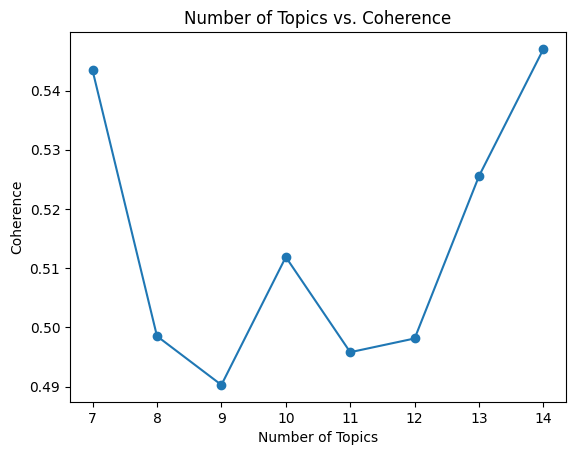

In [ ]:
from matplotlib import pyplot as plt

x_val = [x[0] for x in coherence]
y_val = [x[1] for x in coherence]

plt.plot(x_val,y_val)
plt.scatter(x_val,y_val)
plt.title('Number of Topics vs. Coherence')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')
plt.xticks(x_val)
plt.show()

###### ////// Lda slutt ///////

###### ////// Visualizing ///////

In [ ]:
k = 3

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(doc_term_matrix, num_topics=3, id2word = dictionary, passes=40,\
               iterations=200,  chunksize = 10000, eval_every = None, random_state=0)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
n_words = 10

topic_words = pd.DataFrame({})

for i, topic in enumerate(ldamodel.get_topics()):
    top_feature_ids = topic.argsort()[-n_words:][::-1]
    feature_values = topic[top_feature_ids]
    # words = [dictionary[id] for id in top_feature_ids]
    words = [dictionary[id] for id in top_feature_ids if dictionary[id] != "gammel"]
    topic_df = pd.DataFrame({'word': feature_values, 'frequency': words, 'topic': i})
    topic_words = pd.concat([topic_words, topic_df], ignore_index=True)

# topic_words.head()



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


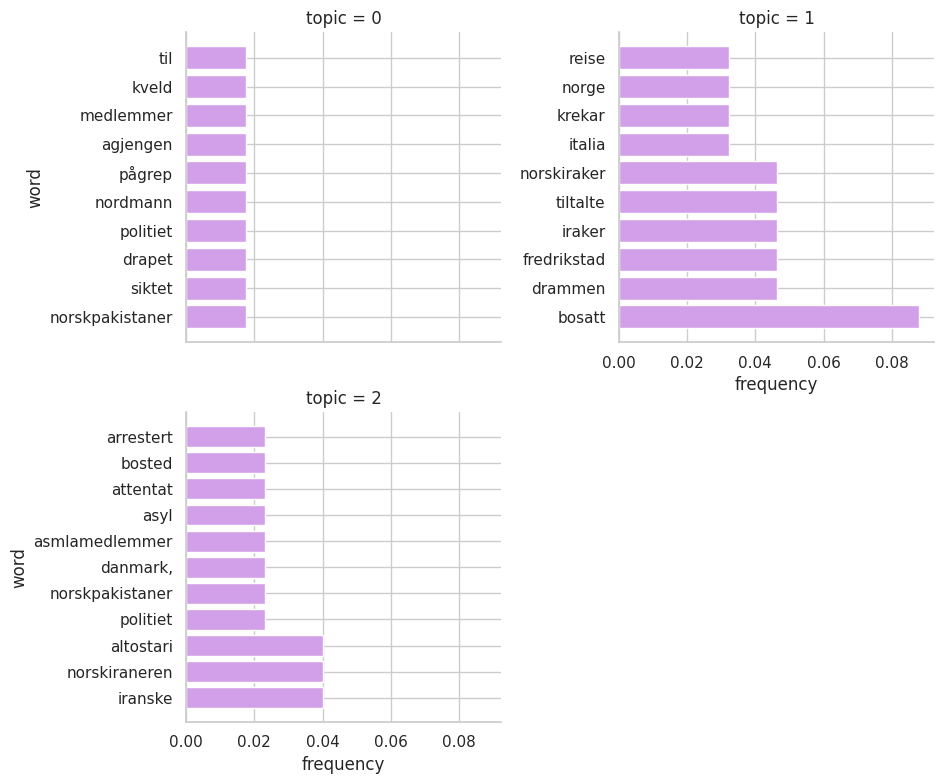

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt

sns.set_style('whitegrid')
# plt.colorbar
def plot_barh(freq, words, **kwargs):
  # palette = sns.color_palette("husl", len(freq))
  plt.barh(y=freq, width=words, facecolor="#d1a0e8", **kwargs)

g = sns.FacetGrid(topic_words, col="topic", col_wrap=2, sharey=False, height=4, aspect=1.2)

g.map(plot_barh, "frequency", "word")

plt.show()

# g.savefig("target_terms_norsk_LDa_k_3.png")

In [ ]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1     -0.144954  0.0       1        1  55.015023
2      0.129767  0.0       2        1  42.651193
0      0.015187  0.0       3        1   2.333784, topic_info=           Term      Freq     Total Category  logprob  loglift
4        gammel  6.000000  6.000000  Default  30.0000  30.0000
0        bosatt  4.000000  4.000000  Default  29.0000  29.0000
2       drammen  2.000000  2.000000  Default  28.0000  28.0000
10  norskiraker  2.000000  2.000000  Default  27.0000  27.0000
13     tiltalte  2.000000  2.000000  Default  26.0000  26.0000
..          ...       ...       ...      ...      ...      ...
7        italia  0.037659  1.903698   Topic3  -4.0433  -0.1653
8        krekar  0.037659  1.903698   Topic3  -4.0433  -0.1653
9         norge  0.037659  1.903698   Topic3  -4.0433  -0.1653
11        reise  0.037659  1.903698   Topic3  -4.0433  -0.1653
12   rettssaken  0.037659  1.903698   Topic3  -4.0433  -0.1653

[145 rows x 6 columns], token_table=      Topic      Freq                    Term
term                                         
52        1  0.833217                agjengen
17        2  1.080677               altostari
18        2  0.851753               arrestert
19        2  0.851753          asmlamedlemmer
20        2  0.851753                    asyl
21        2  0.851753                attentat
0         1  0.848074                  bosatt
22        2  0.851753                  bosted
44        2  0.851990                cappelen
23        2  0.851753                danmark,
24        2  0.851753                  danske
1         1  1.050587                   delta
2         1  0.767206                 drammen
14        1  0.833781                  drapet
25        2  0.851753  etterretningstjenesten
3         1  0.767207             fredrikstad
4         1  1.025469                  gammel
45        2  0.851991                    hasj
26        2  0.851753                     hor
5         1  0.833018                 hverken
27        2  0.851753                   hyret
6         1  0.767206                  iraker
28        2  1.080677                 iranske
7         1  1.050587                  italia
29        2  0.851753                  kaller
8         1  1.050587                  krekar
53        1  0.833217                   kveld
30        2  0.851753                   livet
31        2  0.851753                    mann
54        1  0.833217               medlemmer
32        2  0.851753             myndigheter
55        1  0.833217                nordmann
9         1  1.050587                   norge
10        1  0.767207             norskiraker
33        2  1.080677           norskiraneren
15        1  0.775432         norskpakistaner
15        2  0.387716         norskpakistaner
34        2  0.851753                 nyheten
35        2  0.851753          opposisjonelle
36        2  0.851753                planlagt
46        1  0.532972                politiet
46        2  0.532972                politiet
37        2  0.851753                politisk
56        1  0.833217                  pågrep
11        1  1.050587                   reise
12        1  1.050587              rettssaken
38        2  0.851753       revolusjonsgarden
16        1  0.833781                  siktet
47        2  0.851990                  solgte
39        2  0.851753                 sverige
48        2  0.851990                     til
13        1  0.767206                tiltalte
40        2  0.851753                 tirsdag
41        2  0.851753                   tyder
42        2  0.851753                  yacoub
49        2  0.851990               «maxopak»
50        2  0.851990                  «opac»
51        2  0.851990                  «opak»
43        2  0.851753               østlandet, R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

####### TFIDF

In [ ]:
tfidf = gensim.models.TfidfModel
tfidf_model = tfidf(corpus=doc_term_matrix, id2word=dictionary)
tfidf_doc = tfidf_model[doc_term_matrix]
lsi_model = gensim.models.LsiModel(tfidf_doc, id2word=dictionary, num_topics=3)

n_words = 10

topic_words = pd.DataFrame({})

for i, topic in enumerate(lsi_model.get_topics()):
    top_feature_ids = topic.argsort()[-n_words:][::-1]
    feature_values = topic[top_feature_ids]
    words = [dictionary[id] for id in top_feature_ids]
    topic_df = pd.DataFrame({'word': feature_values, 'frequency': words, 'topic': i})
    topic_words = pd.concat([topic_words, topic_df], ignore_index=True)

topic_words.head()


# pyLDAvis.gensim.prepare(lsi_model, doc_term_matrix, dictionary)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gensim/models/lsimodel.py:963: DeprecationWarning: `scipy.sparse.sparsetools.csc_matvecs` is deprecated along with the `scipy.sparse.sparsetools` namespace. `scipy.sparse.sparsetools.csc_matvecs` will be removed in SciPy 1.14.0, and the `scipy.sparse.sparsetools` namespace will be removed in SciPy 2.0.0.
  sparsetools.csc_matvecs(


,word,frequency,topic
0,0.522944,bosatt,0
1,0.261472,norskiraker,0
2,0.261472,fredrikstad,0
3,0.261472,drammen,0
4,0.261472,iraker,0


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


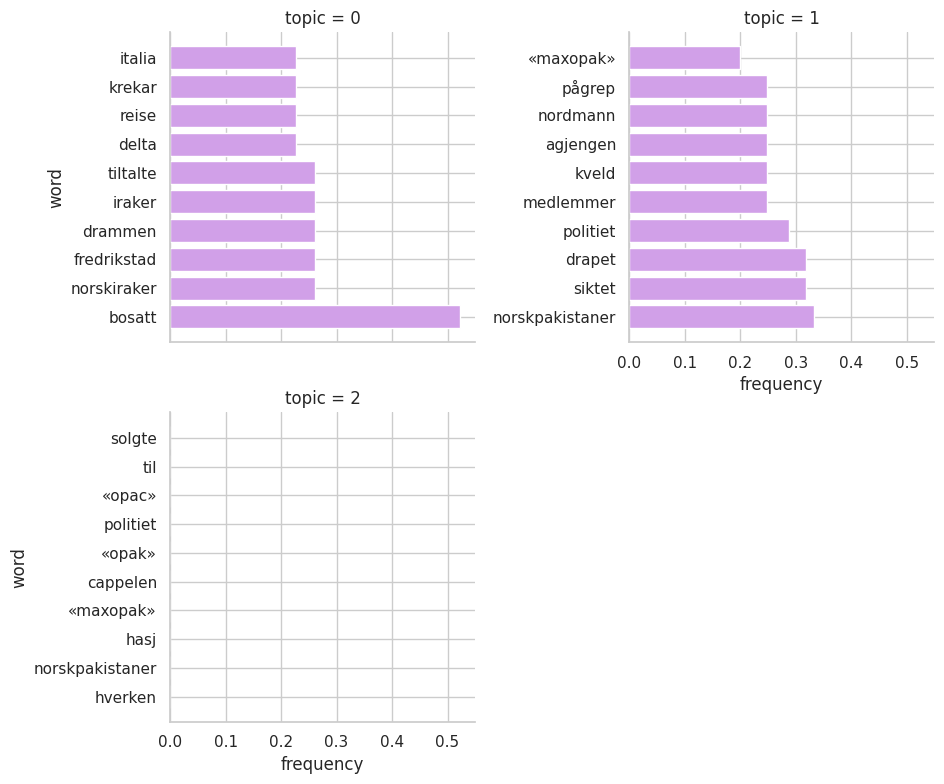

In [ ]:

import seaborn as sns
from matplotlib import pyplot as plt

sns.set_style('whitegrid')
# plt.colorbar
def plot_barh(freq, words, **kwargs):
  # palette = sns.color_palette("husl", len(freq))
  plt.barh(y=freq, width=words, facecolor="#d1a0e8", **kwargs)

g = sns.FacetGrid(topic_words, col="topic", col_wrap=2, sharey=False, height=4, aspect=1.2)

g.map(plot_barh, "frequency", "word")

plt.show()

# g.savefig("target_terms_tfidf_k_3.png")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gensim/models/lsimodel.py:963: DeprecationWarning: `scipy.sparse.sparsetools.csc_matvecs` is deprecated along with the `scipy.sparse.sparsetools` namespace. `scipy.sparse.sparsetools.csc_matvecs` will be removed in SciPy 1.14.0, and the `scipy.sparse.sparsetools` namespace will be removed in SciPy 2.0.0.
  sparsetools.csc_matvecs(


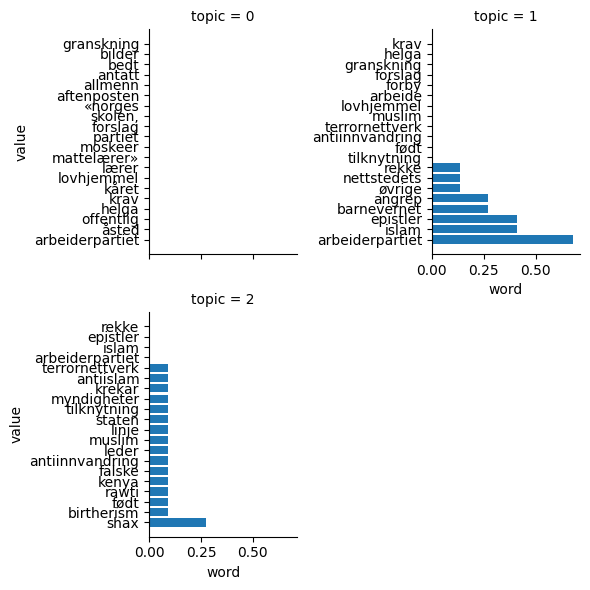

In [ ]:
tfidf = gensim.models.TfidfModel
tfidf_model = tfidf(corpus=doc_term_matrix, id2word=dictionary)
tfidf_doc = tfidf_model[doc_term_matrix]
lsi_model = gensim.models.LsiModel(tfidf_doc, id2word=dictionary, num_topics=6)

n_words = 20

topic_words = pd.DataFrame({})

for i, topic in enumerate(lsi_model.get_topics()):
    top_feature_ids = topic.argsort()[-n_words:][::-1]
    feature_values = topic[top_feature_ids]
    words = [dictionary[id] for id in top_feature_ids]
    topic_df = pd.DataFrame({'value': feature_values, 'word': words, 'topic': i})
    topic_words = pd.concat([topic_words, topic_df], ignore_index=True)

topic_words.head()

g = sns.FacetGrid(topic_words, col="topic", col_wrap=2, sharey=False)
g.map(plt.barh, "word", "value")

In [ ]:
# made token list array into df again
token_df = pl.DataFrame({"tokens":tl})
print(len(token_df))

199829
182


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


tokens,count
str,u32
"""styrke""",2618
"""iran""",2066
"""tyrkia""",1543
"""styrker""",1203
"""usa""",1189
"""norge""",883
"""tyrkiske""",762
"""syria""",739
"""muslimer""",651


In [ ]:
# filter to tokens which appear at least x times
x = 100
cleaned_list = token_df['tokens'].value_counts(sort=True).filter(pl.col("count") > x)
print(len(cleaned_list))
cleaned_list.head(20)

In [ ]:
# Create dictionary from cleaned list of words

from gensim.corpora import Dictionary

df = pl.DataFrame(cleaned_list["tokens"]) # unfiltered, not only top five altså
dictionary = Dictionary(df)

print(dictionary.token2id)

# Term-document frequency - bag of words
corpus = [dictionary.doc2bow(text) for text in df]

# See the text and how it looks like an embedding
print(df[:1][0][:30])
print(corpus[:1][0][:30])

{'afghanistan': 0, 'afghanistan,': 1, 'afghanske': 2, 'allierte': 3, 'amerikansk': 4, 'amerikanske': 5, 'angrep': 6, 'angrepene': 7, 'angrepet': 8, 'arbeidet': 9, 'atomavtalen': 10, 'avtalen': 11, 'bakgrunn': 12, 'barn': 13, 'barna': 14, 'bedre': 15, 'bidra': 16, 'byen': 17, 'bærum': 18, 'dager': 19, 'donald': 20, 'drept': 21, 'erdogan': 22, 'europa': 23, 'familien': 24, 'fjor': 25, 'flyktninger': 26, 'folk': 27, 'forbindelse': 28, 'forhold': 29, 'forrige': 30, 'forsvaret': 31, 'fortsetter': 32, 'frankrike': 33, 'ganger': 34, 'gir': 35, 'gjelder': 36, 'gode': 37, 'grensen': 38, 'gruppen': 39, 'hevder': 40, 'hijab': 41, 'india': 42, 'internasjonale': 43, 'irak': 44, 'irakiske': 45, 'iran': 46, 'iran,': 47, 'irans': 48, 'iransk': 49, 'iranske': 50, 'islam': 51, 'islamic': 52, 'islamistiske': 53, 'islamsk': 54, 'islamske': 55, 'israel': 56, 'kampen': 57, 'kina': 58, 'konflikten': 59, 'kontroll': 60, 'krig': 61, 'krigen': 62, 'kristne': 63, 'kroner': 64, 'kurdiske': 65, 'kveld': 66, 'kvinn

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Exploratory analysis

##### Word cloud

In [ ]:
from wordcloud import WordCloud

In [ ]:
years = [2019, 2017, 2018]

print('Get statistics for articles and relevant articles. Spacy files.')

def get_wordcloud(year):
  print('year:', year)
  print('\n')
  file_path = f'/content/drive/MyDrive/Thesis/Data/{year}/spacy'

  n = len([f for f in os.listdir(file_path) if os.path.isfile(os.path.join(file_path, f))])+1
  print('No. of files to traverse:',n-1)

  all_articles = combine_data_files(year, n, )
  print('Getting lemmas from all articles..')
  articles =  get_lemmas_from_spacy_files(all_articles, 'syntax', False) # Last param = False: Output is not in array form, but in string. True: output is in array form
  print('Extracting relevant articles based on topic terms..\n')
  relevant_articles = match_for_articles(articles, topic_terms, False) # Last param = False: Output is not in array form, but in string. True: output is in array form

  article = ''.join(list(relevant_articles['article']))

  # Print stats
  print(f'No. of all articles in {year}',len(all_articles)) # total articles
  print(f'No. of relevant articles in {year}',len(relevant_articles)) # total muslim related articles

  return article

Get statistics for articles and relevant articles. Spacy files.


In [ ]:
# article = get_wordcloud(2017)
a_df = pl.read_csv('/content/target_terms_articles_with_bi_and_trigrams.csv')
a_df2 = a_df.with_columns(pl.col('article').str.replace_all("'", ""))
article = ''.join(list(a_df2['article']))
# article[5]

'e'

In [ ]:
d = {}
for a, x in bag.values:
    d[a] = x

import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

dict_keys(['muslimer', 'islam', 'norge', 'landet', 'usa', 'tyrkiske', 'tyrkia', 'iran', 'iranske', 'muslimske', 'angrep', 'moskeen', 'angrepet', 'syria', 'skriver', 'politiet', 'trump', 'tyrkiske_myndigheter', 'ønsker', 'byen', 'hijab', 'støtte', 'muslim', 'tyrkisk', 'land', 'folk', 'europa', 'regjeringen', 'kvinner', 'verden', 'erdogan', 'irakiske', 'drept', 'prosent', 'tyrkerne', 'opplyser', 'barn', 'mannen', 'leder', 'afghanske', 'muslimene', 'pakistanske', 'personer', 'iranske myndigheter', 'hevder', 'afghanistan', 'taliban', 'dagen', 'saudiarabia', 'amerikanske'])


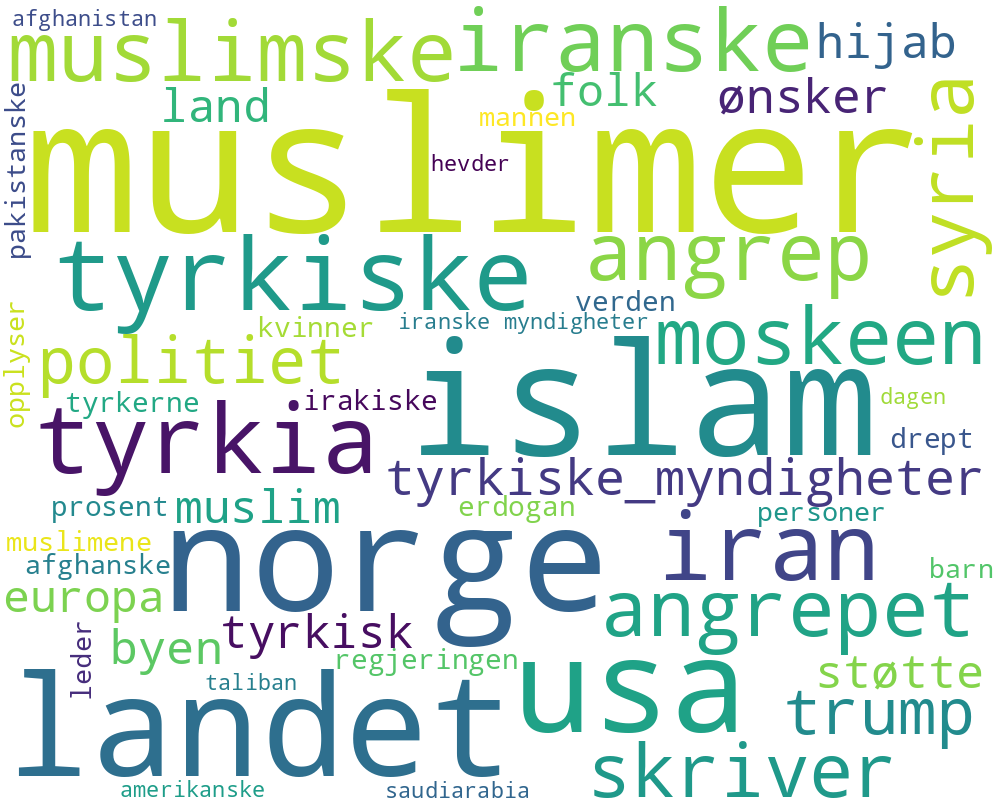

In [ ]:
wordcloud = WordCloud(background_color="white", max_words=50, contour_width=10, contour_color='steelblue', width=1000, height=800)
wordcloud.generate(article)
print(wordcloud.words_.keys())
wordcloud.to_image()

##### Stats

* How many articles per year, of these how many about muslims
* how many articles per year per news paper, of these how many about muslims
* What year are most articles published for all newspapers, of these how many about muslims
* What month in that year has the most articles published

In [ ]:
from datetime import datetime

def convert_dates(df):
  dates = []
  newssites = []

  for row in df.rows(named=True):
    row_date = row['date']
    try:
      date = datetime.strptime(row_date,'%d.%m.%Y').date()
      dates.append(date.month)
      newssites.append(row['newssite'])
    except Exception as e:
      print(f'Could not parse {row_date}. Error: {e}')
      continue

  dates_df = pl.DataFrame({'month':dates,'newssite':newssites})
  return dates_df

In [ ]:
years = [2017, 2018]

print('Get statistics for articles and relevant articles. Spacy files.')
for year in years:
  print('year:', year)
  print('\n')
  file_path = f'/content/drive/MyDrive/Thesis/Data/{year}/spacy'

  n = len([f for f in os.listdir(file_path) if os.path.isfile(os.path.join(file_path, f))])+1
  print('No. of files to traverse:',n-1)

  all_articles = combine_data_files(year, n)
  print('Getting lemmas from all articles..')
  articles =  get_lemmas_from_spacy_files(all_articles, 'syntax', True) # Last param = False: Output is not in array form, but in string. True: output is in array form
  print('Extracting relevant articles based on topic terms..\n')
  relevant_articles = match_for_articles(articles, all_target_terms, True) # Last param = False: Output is not in array form, but in string. True: output is in array form

  # Print stats
  print(f'No. of all articles in {year}',len(all_articles)) # total articles
  print(f'No. of relevant articles in {year}',len(relevant_articles)) # total muslim related articles

  per_newspaper = all_articles['newssite'].value_counts(sort=True)
  print(f'Per newspaper for all articles in {year}',per_newspaper.head(10))

  per_newspaper = relevant_articles['newssite'].value_counts(sort=True)
  print(f'Per newspapers relevant articles in {year}',per_newspaper.head(10))

  article_dates = convert_dates(all_articles)
  relevant_dates = convert_dates(relevant_articles)

  per_month = relevant_dates['month'].value_counts(sort=True)
  print(f'Relevant articles dates in {year}:', per_month.head(12))

  per_month = article_dates['month'].value_counts(sort=True)
  print(f'all article dates in {year}', per_month.head(12))
  print('============================================\n')

Get statistics for articles and relevant articles. Spacy files.
year: 2017


No. of files to traverse: 119
20
40
60
80
100


KeyboardInterrupt: 

In [ ]:
file_path = f'/content/drive/MyDrive/Thesis/Data/2017/spacy'
n = len([f for f in os.listdir(file_path) if os.path.isfile(os.path.join(file_path, f))])+1
print('No. of files to traverse:',n-1)

all_articles = combine_data_files(year, n)
print('Getting lemmas from all articles..')
articles =  get_lemmas_from_spacy_files(all_articles, 'syntax', True) # Last param = False: Output is not in array form, but in string. True: output is in array form
print('Extracting relevant articles based on topic terms..\n')
relevant_articles = match_for_articles(articles, all_target_terms, True) # Last param = False: Output is not in array form, but in string. True: output is in array form



No. of files to traverse: 119
20
40
60
80
100
Getting lemmas from all articles..
Extracting relevant articles based on topic terms..



NameError: name 'all_target_terms' is not defined

In [ ]:
relevant_articles = match_for_articles(articles, (target_terms + target_terms_nationalities + target_terms_norsk), True) # Last param = False: Output is not in array form, but in string. True: output is in array form

Total rows to traverse: 179872
Rows traversed: 0
Rows traversed: 100000


###### Only for 2017 - relevant articles - adresseavisa

In [ ]:
# Print stats
print(f'No. of all articles in {year}',len(all_articles)) # total articles
print(f'No. of relevant articles in {year}',len(relevant_articles)) # total muslim related articles

per_newspaper = all_articles['newssite'].value_counts(sort=True)
print(f'Per newspaper for all articles in {year}',per_newspaper.head(10))

per_newspaper = relevant_articles['newssite'].value_counts(sort=True)
print(f'Per newspapers relevant articles in {year}',per_newspaper.head(10))

article_dates = convert_dates(all_articles)
relevant_dates = convert_dates(relevant_articles)

per_month = relevant_dates['month'].value_counts(sort=True)
print(f'Relevant articles dates in {year}:', per_month.head(12))

per_month = article_dates['month'].value_counts(sort=True)
print(f'all article dates in {year}', per_month.head(12))
print('============================================\n')

No. of all articles in 2017 179872
No. of relevant articles in 2017 6219
Per newspaper for all articles in 2017 shape: (10, 2)
┌──────────┬───────┐
│ newssite ┆ count │
│ ---      ┆ ---   │
│ str      ┆ u32   │
╞══════════╪═══════╡
│ ap       ┆ 32422 │
│ db       ┆ 29730 │
│ aa       ┆ 28702 │
│ vg       ┆ 21988 │
│ …        ┆ …     │
│ da       ┆ 13717 │
│ bt       ┆ 10034 │
│ nl       ┆ 5380  │
│ fv       ┆ 5134  │
└──────────┴───────┘
Per newspapers relevant articles in 2017 shape: (10, 2)
┌──────────┬───────┐
│ newssite ┆ count │
│ ---      ┆ ---   │
│ str      ┆ u32   │
╞══════════╪═══════╡
│ aa       ┆ 1803  │
│ db       ┆ 1082  │
│ ap       ┆ 944   │
│ vg       ┆ 923   │
│ …        ┆ …     │
│ sa       ┆ 276   │
│ bt       ┆ 240   │
│ fv       ┆ 50    │
│ nl       ┆ 48    │
└──────────┴───────┘
Could not parse None. Error: strptime() argument 1 must be str, not None
Could not parse None. Error: strptime() argument 1 must be str, not None
Could not parse None. Error: strptime() a

In [ ]:
# relevant_articles.head()
pl.Config.set_fmt_str_lengths(200)
pl.Config.set_tbl_rows(20)
aa_articles = relevant_articles.filter(pl.col("newssite") == 'aa')
top_10_terms = aa_articles['relevant_term'].value_counts(sort=True)[:10]
print(aa_articles.head(10))
print(top_10_terms)
print(relevant_dates.filter(pl.col("newssite") == 'aa')['month'].value_counts(sort=True).head())

shape: (10, 4)
┌──────────┬────────────┬──────────────────────────────────────────────┬───────────────┐
│ newssite ┆ date       ┆ article                                      ┆ relevant_term │
│ ---      ┆ ---        ┆ ---                                          ┆ ---           │
│ str      ┆ str        ┆ list[str]                                    ┆ str           │
╞══════════╪════════════╪══════════════════════════════════════════════╪═══════════════╡
│ aa       ┆ 19.04.2017 ┆ ["europarådet", "godta", … "©ntb"]           ┆ tyrkisk       │
│ aa       ┆ 27.09.2017 ┆ ["ankomme", "kabul", … "©ntb"]               ┆ afghansk      │
│ aa       ┆ 20.02.2017 ┆ ["pen", "nasjonal", … "©ntb"]                ┆ islamsk       │
│ aa       ┆ 26.07.2017 ┆ ["innvandringsminister", "sylvi", … "for"]   ┆ hijab         │
│ aa       ┆ 09.05.2017 ┆ ["våge", "modig", … "©ntb"]                  ┆ norsksomalisk │
│ aa       ┆ 01.03.2017 ┆ ["wilders", "opplyse", … "©ntb"]             ┆ marokkansk    │
│ aa  